In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [41]:
df = pd.read_csv("heart.csv")

In [42]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [43]:
df.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1888.0,54.354343,9.081505,29.0,47.75,55.0,61.0,77.0
sex,1888.0,0.688559,0.463205,0.0,0.00,1.0,1.0,1.0
cp,1888.0,1.279131,1.280877,0.0,0.00,1.0,2.0,4.0
trestbps,1888.0,131.549258,17.556985,94.0,120.00,130.0,140.0,200.0
chol,1888.0,246.855403,51.609329,126.0,211.00,241.0,276.0,564.0
fbs,1888.0,0.148305,0.355496,0.0,0.00,0.0,0.0,1.0
restecg,1888.0,0.597458,0.638820,0.0,0.00,1.0,1.0,2.0
thalach,1888.0,149.424258,23.006153,71.0,133.00,152.0,166.0,202.0
exang,1888.0,0.331568,0.470901,0.0,0.00,0.0,1.0,1.0
oldpeak,1888.0,1.053761,1.161344,0.0,0.00,0.8,1.6,6.2


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

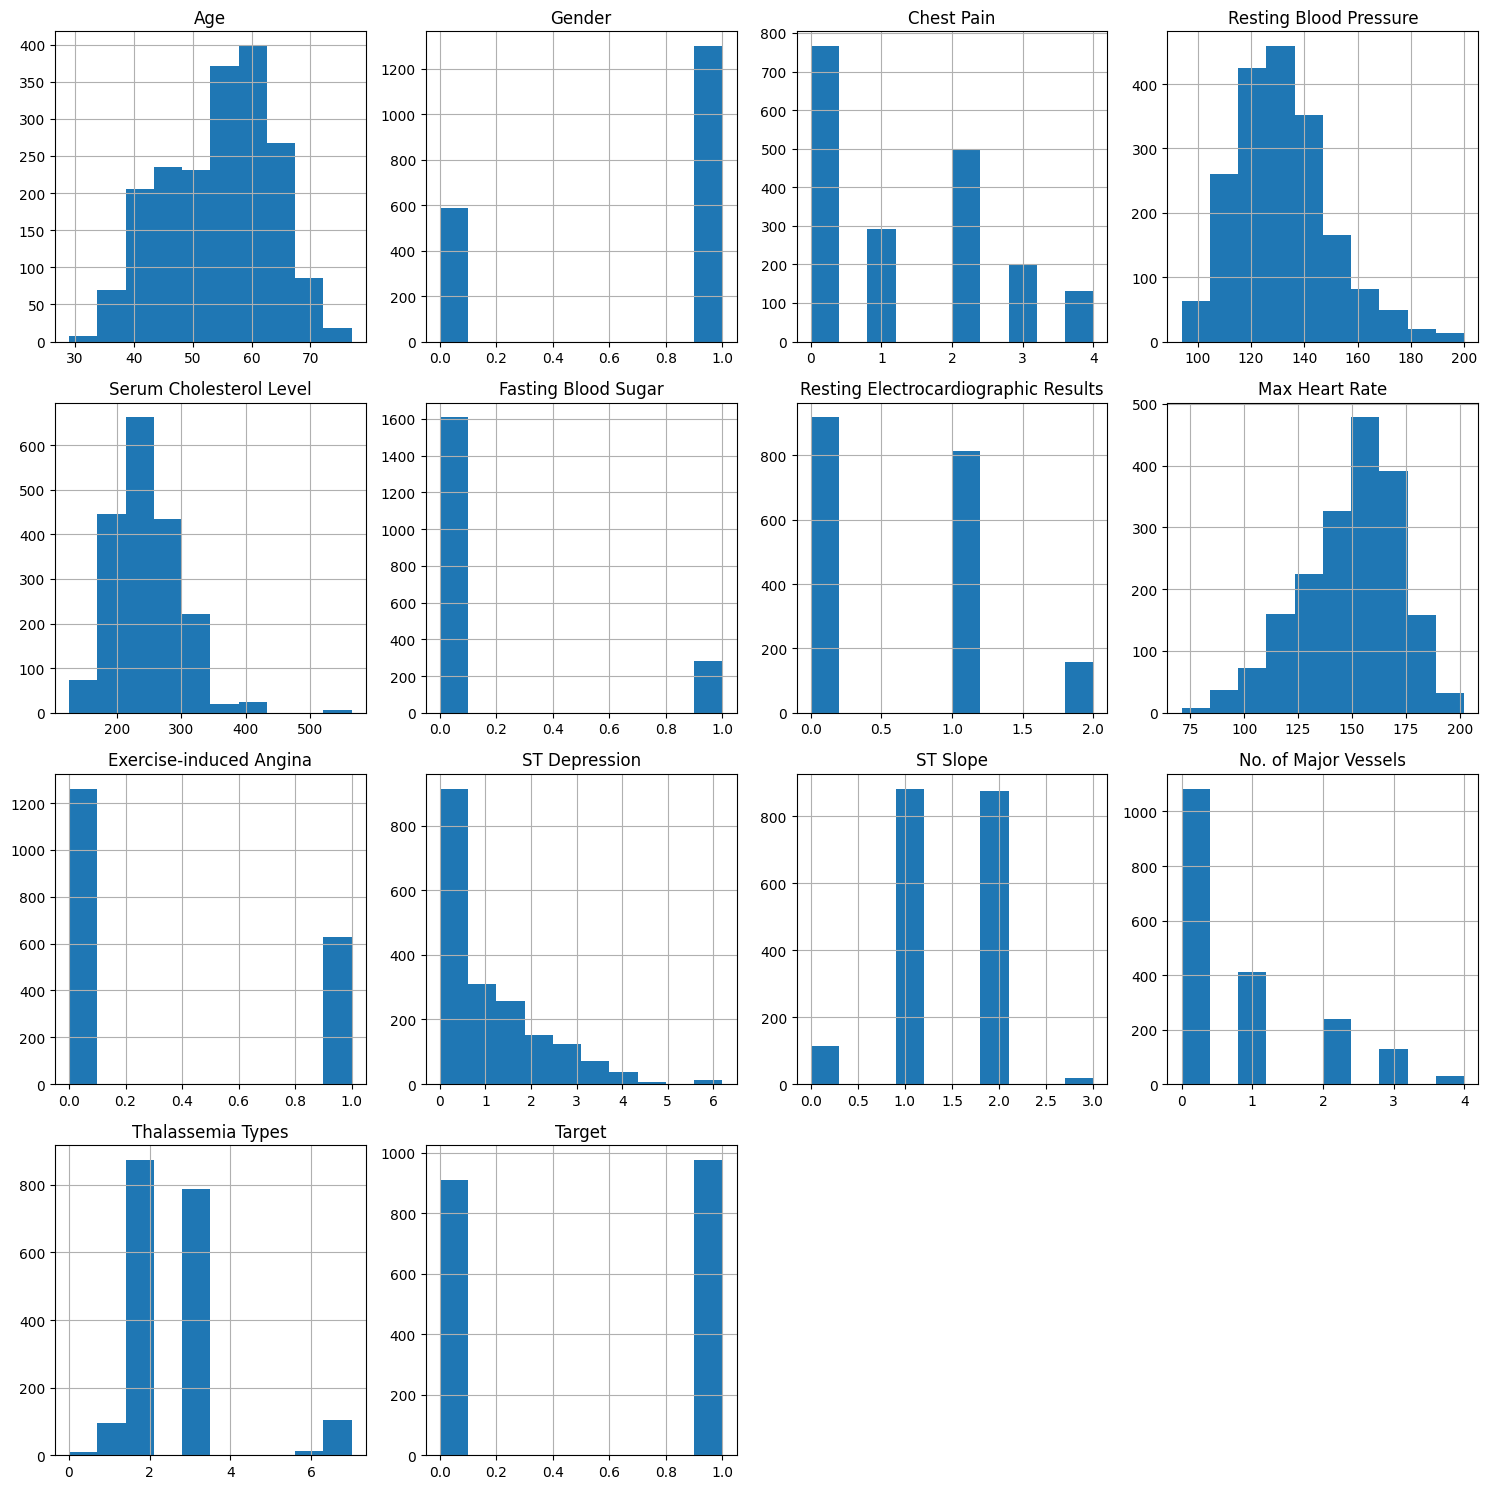

In [46]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (15, 15)) 
axes = axes.flatten()

titles = ["Age", "Gender", "Chest Pain", "Resting Blood Pressure", "Serum Cholesterol Level",
                     "Fasting Blood Sugar", "Resting Electrocardiographic Results", "Max Heart Rate",
                     "Exercise-induced Angina", "ST Depression", "ST Slope", "No. of Major Vessels",
                     "Thalassemia Types", "Target"]

for i, column in enumerate(df.columns):
    df[column].hist(ax=axes[i])
    axes[i].set_title(titles[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Patients')

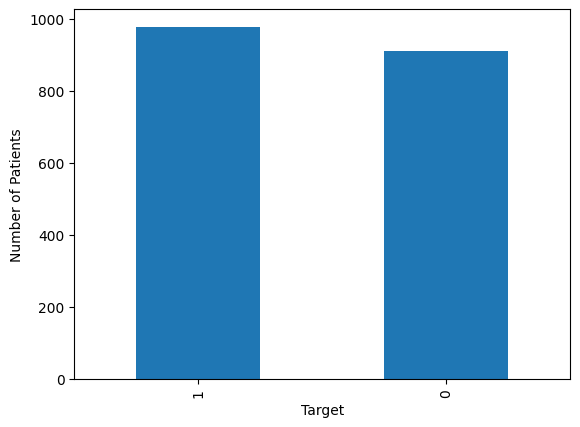

In [47]:
target_count = df['target'].value_counts()
target_count.plot(kind = 'bar')

plt.xlabel('Target')
plt.ylabel('Number of Patients')

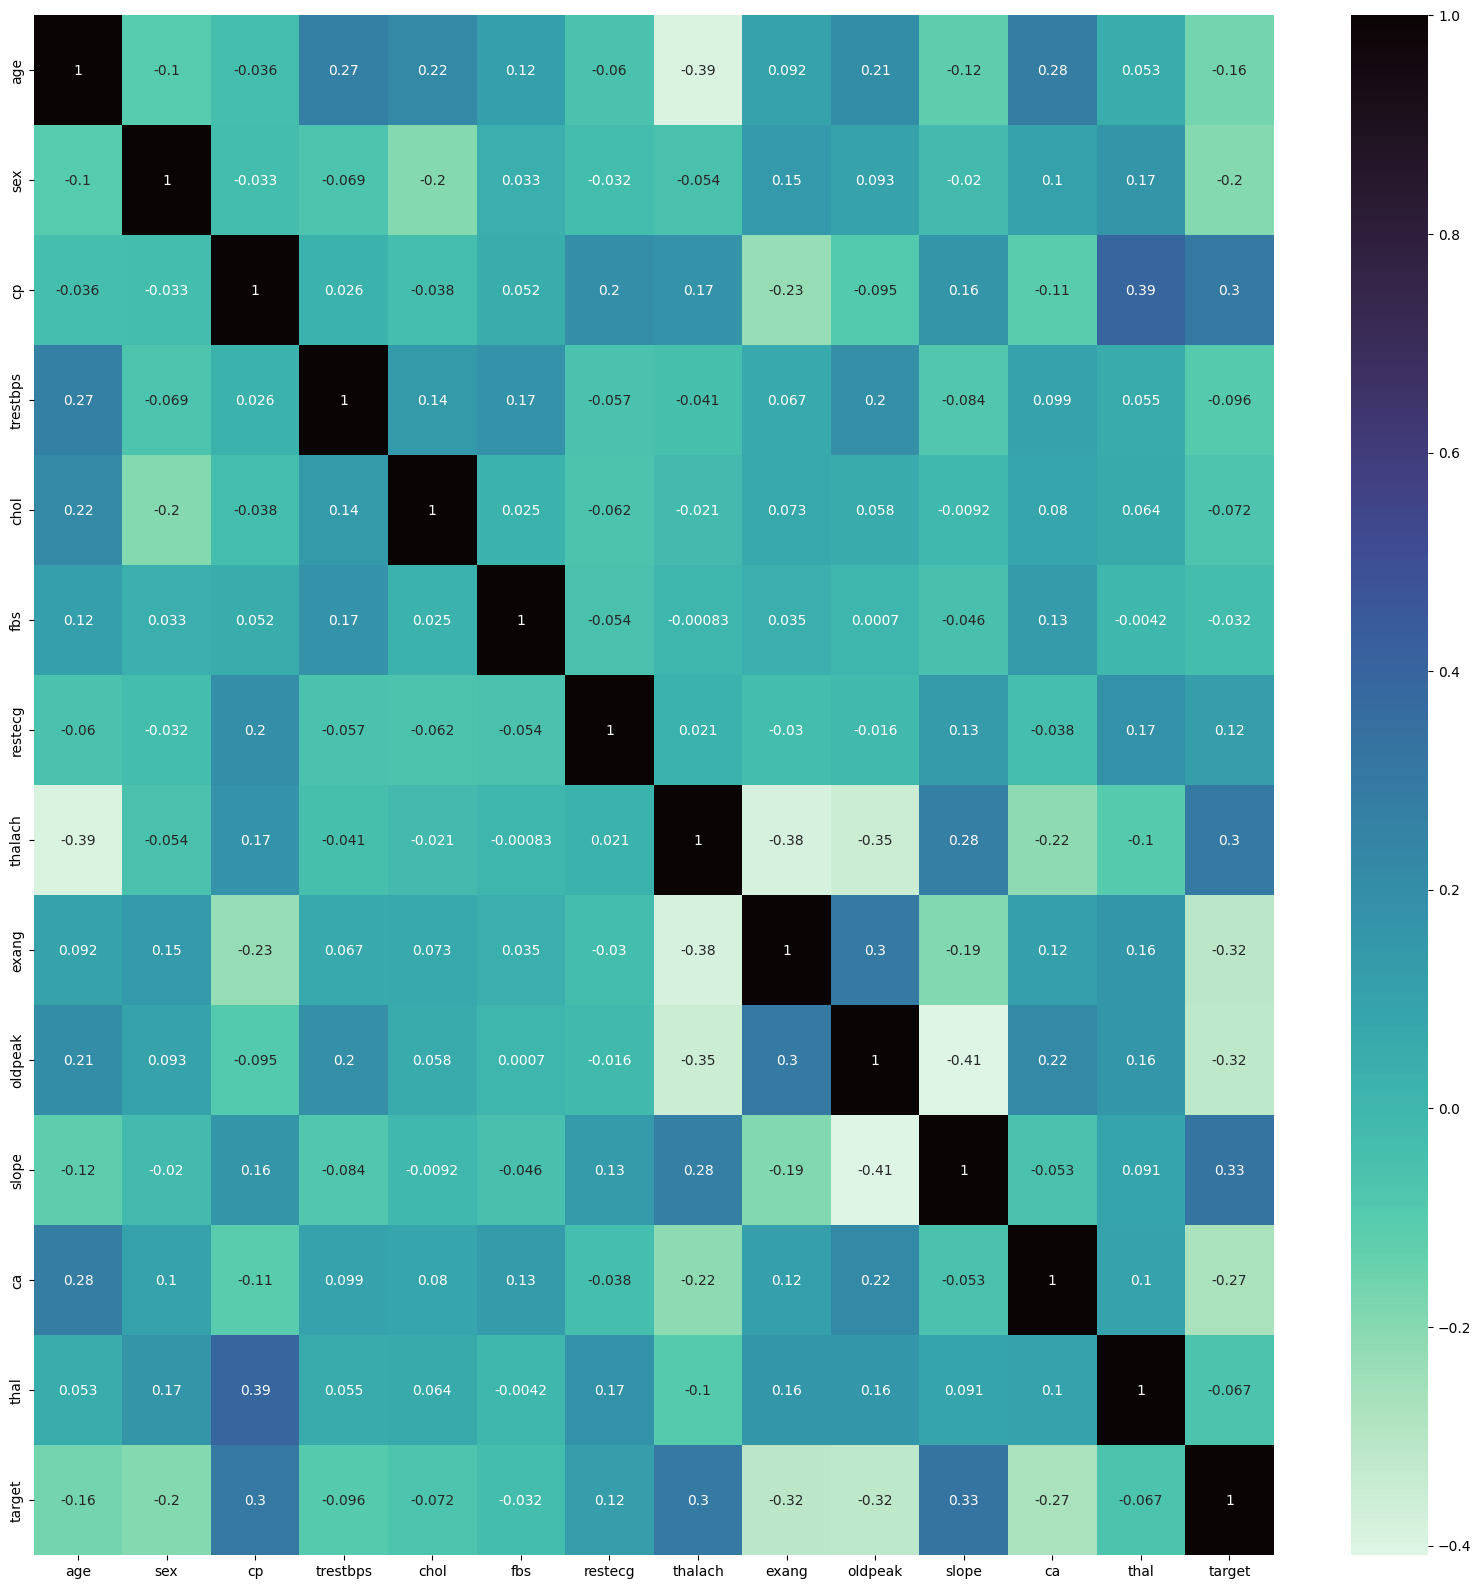

In [48]:
corr_matrix = df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, cmap = 'mako_r', annot = True)
plt.show()

In [49]:
corr_target = abs(corr_matrix['target']).sort_values(ascending= False)
relevant_features = [indices for indices, _ in corr_target[corr_target > 0.1].items()]

dataset = df[relevant_features]
dataset = pd.get_dummies(dataset, columns = ['slope', 'exang', 'cp', 'ca', 'sex', 'restecg'], dtype= int)

column_names = dataset.drop('target', axis = 1).columns

dataset

,target,oldpeak,thalach,age,slope_0,slope_1,slope_2,slope_3,exang_0,exang_1,...,ca_0,ca_1,ca_2,ca_3,ca_4,sex_0,sex_1,restecg_0,restecg_1,restecg_2
0,1,2.3,150,63,1,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
1,1,3.5,187,37,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,1.4,172,41,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0
3,1,0.8,178,56,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
4,1,0.6,163,57,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,0,1.9,138,60,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1884,0,1.8,120,46,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1885,0,0.8,162,59,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
1886,0,0.0,164,54,0,0,1,0,1,0,...,0,1,0,0,0,0,1,1,0,0


In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = ['age', 'oldpeak', 'thalach']
dataset[cols] = scaler.fit_transform(dataset[cols])

In [51]:
dataset.head(10)

,target,oldpeak,thalach,age,slope_0,slope_1,slope_2,slope_3,exang_0,exang_1,...,ca_0,ca_1,ca_2,ca_3,ca_4,sex_0,sex_1,restecg_0,restecg_1,restecg_2
0,1,1.073386,0.025032,0.952259,1,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
1,1,2.106945,1.633724,-1.911461,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,0.298216,0.981551,-1.470888,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0
3,1,-0.218564,1.242420,0.181258,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
4,1,-0.390824,0.590248,0.291401,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
5,1,-0.563084,-0.061924,0.291401,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
6,1,0.212086,0.155467,0.181258,0,1,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0
7,1,-0.907604,1.025030,-1.140459,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
8,1,-0.476954,0.546770,-0.259315,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
9,1,0.470476,1.068508,0.291401,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0


In [52]:
from sklearn.model_selection import train_test_split

X = dataset.drop('target', axis = 1).values
Y = dataset['target'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y)

Optimal number of neighbors is 1
Classifier accuracy is 96.822%


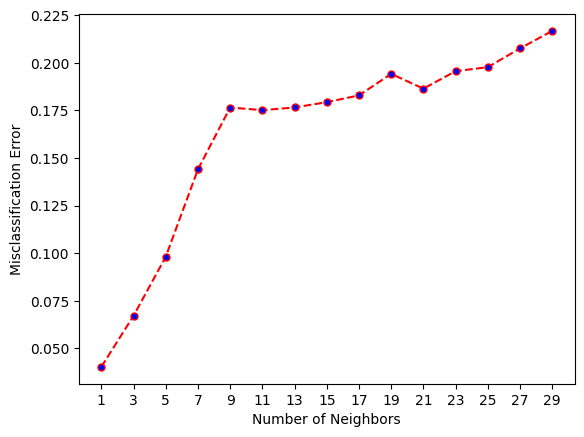

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors = range(1, 30, 2)
cv_scores_knn = []

for k in neighbors: 
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores_knn.append(scores.mean())

error_rate = [1 - x for x in cv_scores_knn]
optimal_k = neighbors[np.argmin(error_rate)]

model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print(f'Optimal number of neighbors is {optimal_k}')
print(f'Classifier accuracy is {accuracy_score(y_test, predictions) * 100:.3f}%')

plt.plot(neighbors, error_rate, color = 'red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=5)
plt.xticks(neighbors)
plt.xlabel("Number of Neighbors")
plt.ylabel("Misclassification Error")
plt.show()


Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}
Best Cross Validation Accuracy: 0.9604538894142239

Tuned Performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       220
           1       0.97      0.98      0.97       252

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



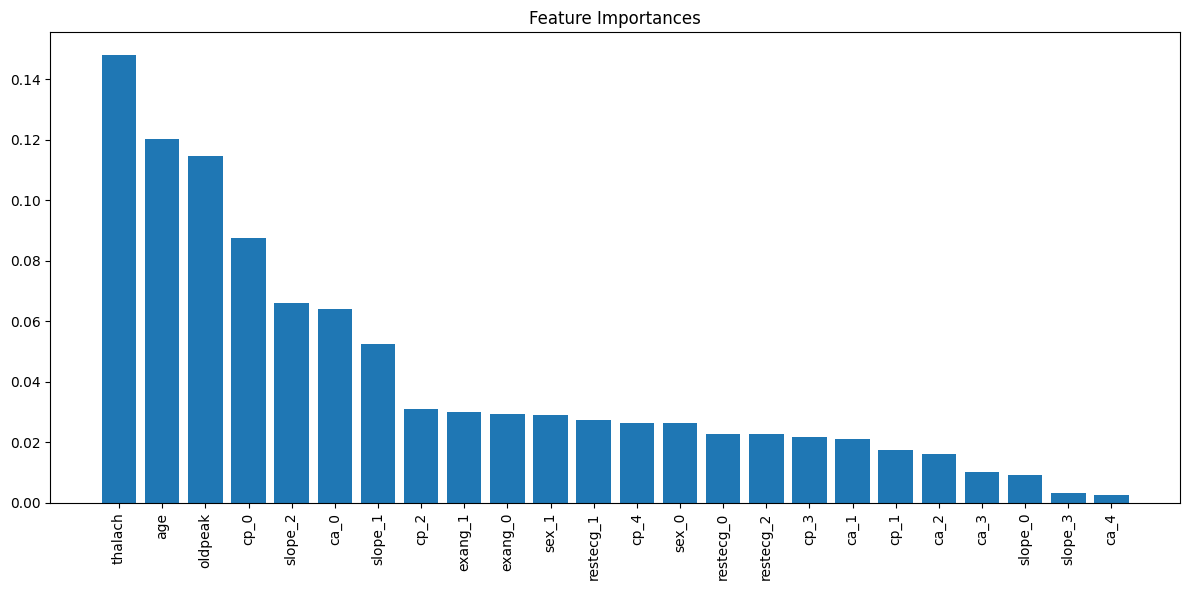

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter combinations to try
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(x_train, y_train)

best_rf = rf_random_search.best_estimator_
y_pred = best_rf.predict(x_test)

print("\nBest Parameters:", rf_random_search.best_params_)
print("Best Cross Validation Accuracy:", rf_random_search.best_score_)
print("\nTuned Performance:")
print(classification_report(y_test, y_pred))

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), column_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [55]:
from sklearn.svm import SVC

baseline_svm = SVC(kernel= 'linear', random_state = 42)
baseline_svm.fit(x_train, y_train)

predictions = baseline_svm.predict(x_test)
print(f"Baseline Accuracy: {accuracy_score(y_test, predictions):.3f}")
print(classification_report(y_test, predictions))

Baseline Accuracy: 0.771
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       220
           1       0.78      0.80      0.79       252

    accuracy                           0.77       472
   macro avg       0.77      0.77      0.77       472
weighted avg       0.77      0.77      0.77       472



In [56]:
param_grid = [
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},
     
    {'kernel': ['rbf'],
     'C': [0.1, 1, 10, 100],
     'gamma': ['scale', 'auto', 0.1, 1, 10]},
     
    {'kernel': ['poly'],
     'C': [0.1, 1, 10],
     'degree': [2, 3, 4],
     'gamma': ['scale', 'auto']}
]

svm_grid_search = GridSearchCV(SVC(random_state = 42, class_weight= 'balanced'), 
                           param_grid, 
                           cv = 10, 
                           scoring = 'accuracy', 
                           n_jobs = -1)

svm_grid_search.fit(x_train, y_train)

print("Best Parameters:", svm_grid_search.best_params_)
print("Best Cross Validation Accuracy:", svm_grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Cross Validation Accuracy: 0.9569273798821298


In [ ]:
optimal_svm_model_exhaustive: SVC = svm_grid_search.best_estimator_

predictions_exhaustive = optimal_svm_model_exhaustive.predict(x_test)
print(f"Tuned Accuracy: {accuracy_score(y_test, predictions_exhaustive):.3f}")
print(classification_report(y_test, predictions_exhaustive))

Tuned Accuracy: 0.970
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       220
           1       0.98      0.97      0.97       252

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



In [59]:
from scipy.stats import loguniform

param_dist = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': loguniform(1e-2, 1e2), #regularization parameter
    'gamma': loguniform(1e-4, 1e1),
    'degree': [2, 3, 4]
}

svm_random_search = RandomizedSearchCV(SVC(random_state = 42, class_weight= 'balanced'),
                                   param_dist, 
                                   n_iter = 50, 
                                   cv = 10, 
                                   scoring = 'accuracy', 
                                   n_jobs = -1)
svm_random_search.fit(x_train, y_train)

print("Best Parameters:", svm_random_search.best_params_)
print("Best Cross Validation Accuracy:", svm_random_search.best_score_)

Best Parameters: {'C': 26.973733533663165, 'degree': 4, 'gamma': 0.7605540259009523, 'kernel': 'rbf'}
Best Cross Validation Accuracy: 0.9576116272100691


In [60]:
optimal_svm_model_random: SVC = svm_random_search.best_estimator_

predictions_random = optimal_svm_model_random.predict(x_test)
print(f"Tuned Accuracy: {accuracy_score(y_test, predictions_random):.3f}")
print(classification_report(y_test, predictions_random))

Tuned Accuracy: 0.966
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       220
           1       0.97      0.97      0.97       252

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



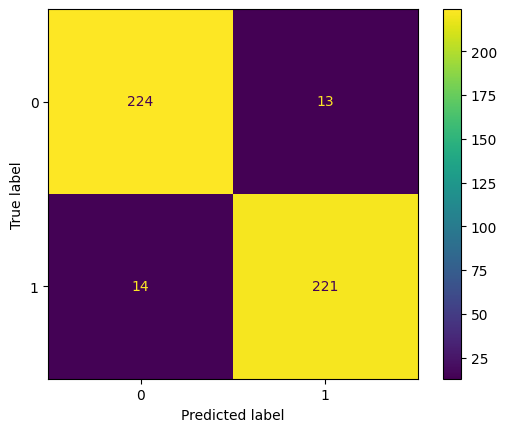

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions_random)
plt.show()